In [1]:
import numpy as np
from matplotlib import pyplot as plt
import h5py
import json
import scipy as sp

In [2]:
events = json.load(open("./LOSC_Event_tutorial-master/BBH_events_v3.json","r"))

In [3]:
def smooth_vector(vec,sig):
    n=len(vec)
    x=np.arange(n)
    x[n//2:]=x[n//2:]-n
    kernel=np.exp(-0.5*x**2/sig**2) #make a Gaussian kernel
    kernel=kernel/kernel.sum()
    vecft=np.fft.rfft(vec)
    kernelft=np.fft.rfft(kernel)
    vec_smooth=np.fft.irfft(vecft*kernelft) #convolve the data with the kernel
    return vec_smooth

def read_template(filename):
    dataFile=h5py.File(filename,'r')
    template=dataFile['template']
    tp=template[0]
    tx=template[1]
    return tp,tx

def read_file(filename):
    dataFile=h5py.File(filename,'r')
    dqInfo = dataFile['quality']['simple']
    qmask=dqInfo['DQmask'][...]

    meta=dataFile['meta']
    #gpsStart=meta['GPSstart'].value
    gpsStart=meta['GPSstart'][()]
    #print meta.keys()
    #utc=meta['UTCstart'].value
    utc=meta['UTCstart'][()]
    #duration=meta['Duration'].value
    duration=meta['Duration'][()]
    #strain=dataFile['strain']['Strain'].value
    strain=dataFile['strain']['Strain'][()]
    dt=(1.0*duration)/len(strain)

    dataFile.close()
    return strain,dt,utc


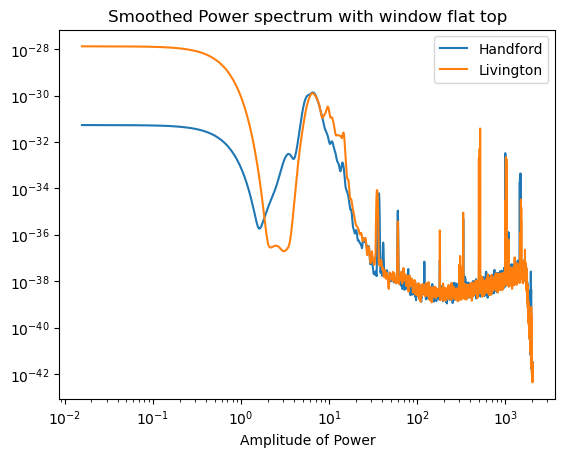

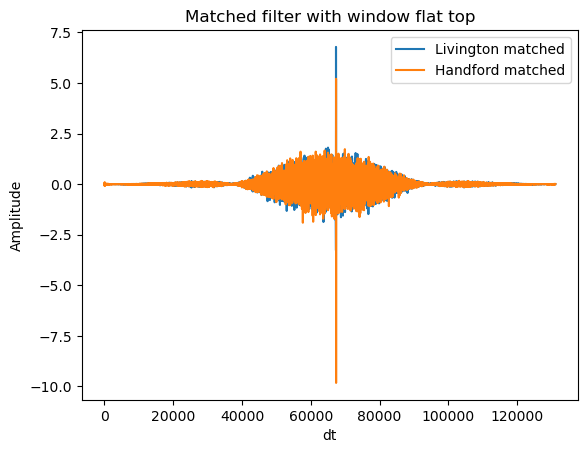

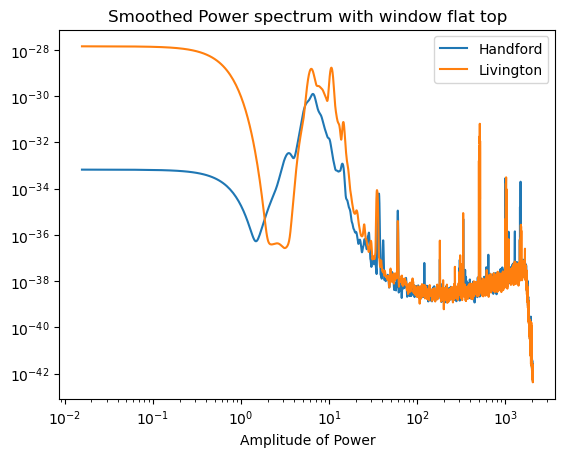

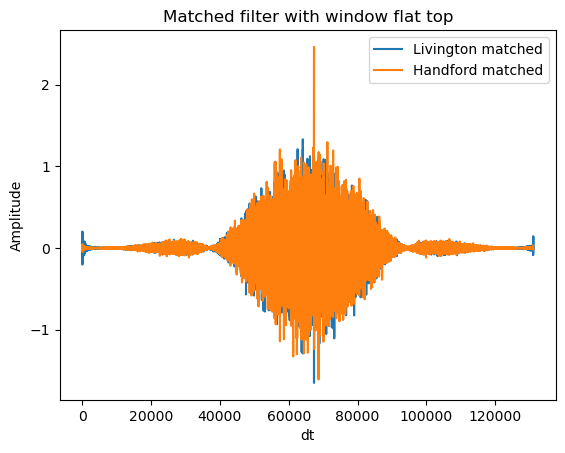

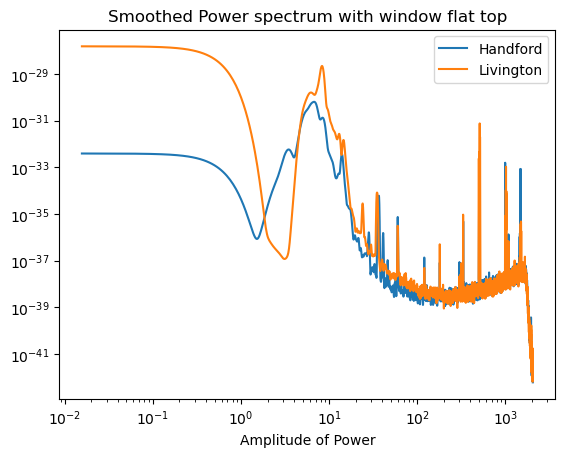

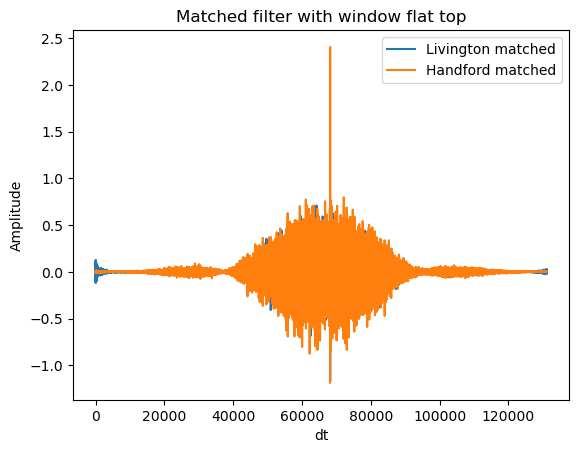

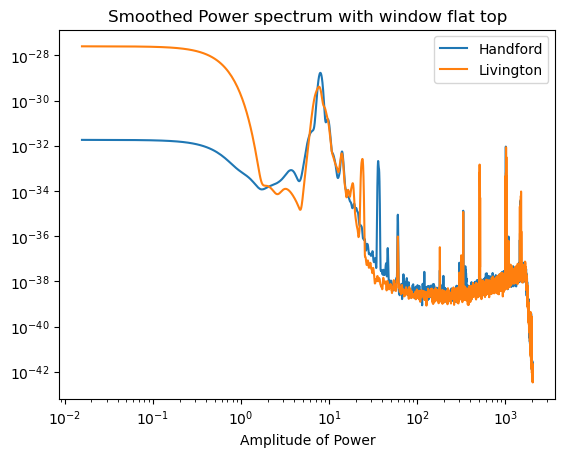

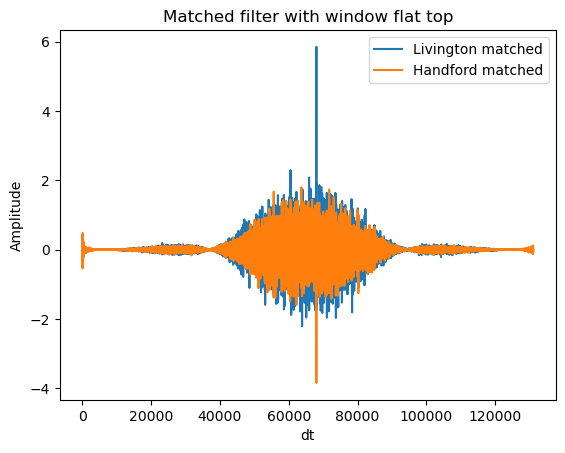

In [6]:
for eventname in events:

    ###a)


    ### Get the data
    event = events[eventname]
    fn_H1 = event['fn_H1']              # File name for H1 data
    fn_L1 = event['fn_L1']              # File name for L1 data
    fn_template = event['fn_template']  # File name for template waveform
    fs = event['fs']                    # Set sampling rate
    tevent = event['tevent']            # Set approximate event GPS time
    fband = event['fband']              # frequency band for bandpassing signal
    strainH,dtH,utcH=read_file("./LOSC_Event_tutorial-master/" +fn_H1)
    strainL,dtL,utcL=read_file("./LOSC_Event_tutorial-master/" +fn_L1)

    tp,tx=read_template("./LOSC_Event_tutorial-master/" + fn_template)
    ### Power spectrum
    power_spectrum_H=np.linspace(-np.pi/2,np.pi/2,len(strainH))
    power_spectrum_L=np.linspace(-np.pi/2,np.pi/2,len(strainL))

    ### Window
    win_H = sp.signal.windows.flattop(power_spectrum_H.size)
    win_L = sp.signal.windows.flattop(power_spectrum_L.size)
    
    ### b) 

    
    ### Noise H
    noise_ft_H=np.fft.fft(win_H*strainH)
    noise_smooth_H=smooth_vector(np.abs(noise_ft_H)**2,10) #Make the noise smooth
    noise_smooth_H=noise_smooth_H[:len(noise_ft_H)//2+1] #will give us same length

    ### Noise L
    noise_ft_L=np.fft.fft(win_L*strainL)
    noise_smooth_L=smooth_vector(np.abs(noise_ft_L)**2,10) #Make the noise smooth
    noise_smooth_L=noise_smooth_L[:len(noise_ft_L)//2+1] #will give us same length

    ### plotting H
    tobs_H=dtH*len(strainH)
    dnu_H=1/tobs_H
    nu_H=np.arange(len(noise_smooth_H))*dnu_H
    nu_H[0]=0.5*nu_H[1]


    ### plotting L
    tobs_L=dtL*len(strainL)
    dnu_L=1/tobs_L
    nu_L=np.arange(len(noise_smooth_L))*dnu_L
    nu_L[0]=0.5*nu_L[1]


    plt.clf()
    plt.title("Smoothed Power spectrum with window flat top")
    plt.loglog(nu_H,np.abs(noise_smooth_H), label="Handford")
    plt.loglog(nu_L,np.abs(noise_smooth_L), label="Livington")
    plt.xlabel("Frequency")
    plt.xlabel("Amplitude of Power")
    plt.legend()
    plt.show()


    ### Noise model of L

    Ninv_L=1/noise_smooth_L
    Ninv_L[nu_L>1500]=0
    Ninv_L[nu_L<20]=0

    # Matched filters of L
    template_ft_L=np.fft.rfft(tp*win_L)
    template_filt_L=template_ft_L*Ninv_L
    data_ft_L=np.fft.rfft(strainL*win_L)
    rhs_L=np.fft.irfft(data_ft_L*np.conj(template_filt_L))

    plt.title("Matched filter with window flat top")

    plt.plot(np.fft.fftshift(rhs_L), label="Livington matched")
    plt.xlabel("dt")
    plt.ylabel("Amplitude")
    ### Noise model of H

    Ninv_H=1/noise_smooth_H
    Ninv_H[nu_H>1500]=0
    Ninv_H[nu_H<20]=0

    # Matched filters of H
    template_ft_H=np.fft.rfft(tp*win_H)
    template_filt_H=template_ft_H*Ninv_H
    data_ft_H=np.fft.rfft(strainH*win_H)
    rhs_H=np.fft.irfft(data_ft_H*np.conj(template_filt_H))
    
    plt.plot(np.fft.fftshift(rhs_H), label="Handford matched")
    plt.legend()
    plt.show()
